#  Часть 1. Чтение и обработка данных.

##### Требуемая структура катологов

### 1. Чистим данные

In [5]:
import numpy as np
import pandas as pd
import matplotlib.image as pltimg
import os
import datetime
import urllib3

from scipy import stats as sts
from matplotlib import pylab as plt

<dl>
<dd>Удаляем поездки с:</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; нулевой длительностью</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; нулевым количеством пассажиров</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; нулевым расстоянием поездки по счётчику</dd>
<dd>&nbsp; &nbsp; &nbsp; &nbsp; координатами начала, не попадающими в прямоугольник Нью-Йорка</dd>    
</dl>

In [2]:
# Проверка количества строк в датафрейме из csv
def check_num_rows(filename, chunksize=1e6):
    num_rows = 0
    for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=chunksize):
        num_rows += chunk.shape[0]
    return num_rows

In [3]:
# Очистка данных. Модифицированный датафрейм записывается в файл. Возвращается кол-во строк до и после очистки.
def clean_data(raw_filename, clean_filename, chunksize=1e6):
    
    # Удаляем очищенный файл, если он существует.
    if os.path.exists(clean_filename):
        os.remove(clean_filename)
    
    num_rows_before = 0
    num_rows_after = 0
    
    for chunk in pd.read_csv(raw_filename, sep=',', header=0, chunksize=chunksize, skipinitialspace=True,
                             parse_dates=[1, 2],
                             date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')):
        
        num_rows_before += chunk.shape[0]
        
        try:
            pick_time_attr = 'tpep_pickup_datetime'
            drop_time_attr = 'tpep_dropoff_datetime'
            _ = chunk[pick_time_attr]
        except KeyError:
            pick_time_attr = 'pickup_datetime'
            drop_time_attr = 'dropoff_datetime'
        
        # get datetime
        """
        chunk[pick_time_attr] = chunk[pick_time_attr].apply(
            lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        chunk[drop_time_attr] = chunk[drop_time_attr].apply(
            lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        """
        pickup_time = np.array([i.timestamp() for i in list(chunk[pick_time_attr])])
        dropoff_time = np.array([i.timestamp() for i in list(chunk[drop_time_attr])])
        chunk['long'] = dropoff_time - pickup_time
        
        chunk['tpep_pickup_datetime'] = chunk[pick_time_attr].apply(
            lambda x: x.replace(minute=0, second=0))
        chunk['tpep_dropoff_datetime'] = chunk[drop_time_attr].apply(
            lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
        
        chunk.drop(columns=['pickup_datetime', 'dropoff_datetime'], inplace=True, errors='ignore')
        
        #clean
        chunk = chunk[(chunk['long'] > 0) &
                      (chunk.passenger_count > 0) & 
                      (chunk.trip_distance > 0) & 
                      (chunk['pickup_longitude'] <= -73.70001) & 
                      (chunk['pickup_longitude'] >= -74.25559) & 
                      (chunk['pickup_latitude'] <= 40.91553) & 
                      (chunk['pickup_latitude'] >= 40.49612)]
        
        num_rows_after += chunk.shape[0]
        
        # Запись. Если файл уже создан, записываем без заголовка.
        header = not(os.path.exists(clean_filename))
        chunk.to_csv(clean_filename, header=header, mode='a')
    
    return num_rows_before, num_rows_after

In [11]:
dir_with_raw_data = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 
                             'raw_data')
files_with_raw_data = os.listdir(dir_with_raw_data)
dir_with_clean_data = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 
                             'clean_data')

In [5]:
files_with_raw_data.sort()
files_with_raw_data

['yellow_tripdata_2014-05.csv',
 'yellow_tripdata_2014-06.csv',
 'yellow_tripdata_2014-07.csv',
 'yellow_tripdata_2014-08.csv',
 'yellow_tripdata_2014-09.csv',
 'yellow_tripdata_2014-10.csv',
 'yellow_tripdata_2014-11.csv',
 'yellow_tripdata_2014-12.csv',
 'yellow_tripdata_2015-01.csv',
 'yellow_tripdata_2015-02.csv',
 'yellow_tripdata_2015-03.csv',
 'yellow_tripdata_2015-04.csv',
 'yellow_tripdata_2015-05.csv',
 'yellow_tripdata_2015-06.csv',
 'yellow_tripdata_2015-07.csv',
 'yellow_tripdata_2015-08.csv',
 'yellow_tripdata_2015-09.csv',
 'yellow_tripdata_2015-10.csv',
 'yellow_tripdata_2015-11.csv',
 'yellow_tripdata_2015-12.csv',
 'yellow_tripdata_2016-01.csv',
 'yellow_tripdata_2016-02.csv',
 'yellow_tripdata_2016-03.csv',
 'yellow_tripdata_2016-04.csv',
 'yellow_tripdata_2016-05.csv',
 'yellow_tripdata_2016-06.csv']

In [ ]:
# Поехали.
CHUNKSIZE = 1e6

print('Сверка количества строк')

for file in files_with_raw_data:
    print(file + '...')
    raw_filename = os.path.join(dir_with_raw_data, file)
    clean_filename = os.path.join(dir_with_clean_data, 'cleaned_' + file)
    num_rows_before, num_row_after = clean_data(raw_filename, clean_filename, CHUNKSIZE)
    check = check_num_rows(clean_filename, CHUNKSIZE)
    is_cool = 'YES' if num_row_after == check else 'NO'
    num_removed = num_rows_before - num_row_after
    print('{0}: до-{1}, после-{2}, check-{3}, is_cool-{4}. Удалено {5} строк'.format(file,
                                                                                     num_rows_before, 
                                                                                     num_row_after, 
                                                                                     check, 
                                                                                     is_cool, 
                                                                                     num_removed))

### 2. Считаем поездки

In [6]:
# Получение списка количества поездок по координатам.
def get_trips(x, y):
    west = -74.25559 
    east = -73.70001
    south = 40.49612
    north = 40.91553
    counts = sts.binned_statistic_2d(x, y, None, statistic='count', bins=50, 
                        range=[[west, east], [south, north]])
    return counts.statistic.ravel()

In [7]:
# Получение списка часов в месяце.
def get_hours(date_string):
    now_date = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    now_date = now_date.replace(day=1, hour=0, minute=0, second=0)
    target_month = now_date.month
    now_month = now_date.month
    res_list = []
    while now_month == target_month:
        res_list.append(now_date.strftime('%Y-%m-%d %H:%M:%S'))
        now_date = now_date + datetime.timedelta(hours=1)
        now_month = now_date.month
    return res_list

In [8]:
# Считаем поездки. Модифицирует датафрейм.
def count_trips(count_data, clean_filename, chunksize=1e6):
    
    for chunk in pd.read_csv(clean_filename, sep=',', header=0, chunksize=chunksize):
        
        # Добавляем столбцы часов в датафрейм.
        if count_data.shape[1] < 10:
            hours = get_hours(chunk['tpep_pickup_datetime'][0])
            for hour in hours:
                values = np.zeros((count_data.shape[0],))
                count_data[hour] = values
        
        for hour in chunk['tpep_pickup_datetime'].unique():
            h_chunk = chunk[chunk['tpep_pickup_datetime'] == hour]
            x = np.array(h_chunk['pickup_longitude'])
            y = np.array(h_chunk['pickup_latitude'])
            count_data[hour] = np.array(count_data[hour]) + get_trips(x, y)

In [12]:
regions_filename = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'regions.csv')
regions = pd.read_csv(regions_filename, sep=';', header=0)
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [14]:
clean_files = os.listdir(dir_with_clean_data)
dir_with_count_data = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'count_data')
clean_files.sort()
clean_files

In [16]:
# Считаем, записываем.
CHUNKSIZE = 1e6

for file in clean_files:
    print(file+'...', end='')
    count_data = regions.copy(deep=True)
    clean_filename = os.path.join(dir_with_clean_data, file)
    count_filename = os.path.join(dir_with_count_data, 'count_' + file)
    
    #Если файл существует, удаляем его.
    if os.path.exists(count_filename):
        os.remove(count_filename)
    
    num_rows = count_trips(count_data, clean_filename, CHUNKSIZE)
    count_data.to_csv(count_filename, sep=',', header=True)
    print('DONE')

cleaned_yellow_tripdata_2015-10.csv...DONE
cleaned_yellow_tripdata_2015-11.csv...DONE
cleaned_yellow_tripdata_2015-12.csv...DONE
cleaned_yellow_tripdata_2016-01.csv...DONE
cleaned_yellow_tripdata_2016-02.csv...DONE
cleaned_yellow_tripdata_2016-03.csv...DONE
cleaned_yellow_tripdata_2016-04.csv...DONE
cleaned_yellow_tripdata_2016-05.csv...DONE
cleaned_yellow_tripdata_2016-06.csv...DONE


### 3. Выводим данные

Представлены данные за май 2016г. Значения имен колонок соответствуют часам. Значения в этих колонках - количество поездок

In [12]:
col_ind = [0] + list(range(count_data.shape[1]))[5:]
count_data.iloc[1225:1235, col_ind]

,region,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,...,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00
1225,1226,5.0,6.0,4.0,1.0,1.0,0.0,1.0,1.0,1.0,...,8.0,0.0,0.0,1.0,2.0,3.0,1.0,0.0,6.0,4.0
1226,1227,697.0,866.0,1001.0,859.0,405.0,112.0,68.0,45.0,76.0,...,57.0,60.0,60.0,68.0,90.0,93.0,110.0,169.0,165.0,190.0
1227,1228,1334.0,1420.0,1260.0,966.0,479.0,143.0,103.0,106.0,159.0,...,166.0,165.0,137.0,167.0,209.0,226.0,289.0,342.0,361.0,350.0
1228,1229,992.0,891.0,785.0,545.0,308.0,107.0,113.0,144.0,276.0,...,389.0,398.0,318.0,396.0,463.0,418.0,424.0,452.0,449.0,341.0
1229,1230,1258.0,1022.0,818.0,611.0,379.0,201.0,122.0,189.0,308.0,...,669.0,627.0,594.0,780.0,972.0,951.0,850.0,785.0,734.0,489.0
1230,1231,881.0,713.0,533.0,418.0,353.0,151.0,147.0,158.0,256.0,...,1009.0,814.0,748.0,879.0,1093.0,1094.0,997.0,1099.0,874.0,608.0
1231,1232,1143.0,1005.0,810.0,662.0,512.0,230.0,190.0,265.0,328.0,...,759.0,795.0,687.0,900.0,1321.0,1092.0,1170.0,1438.0,1365.0,925.0
1232,1233,780.0,545.0,363.0,187.0,153.0,82.0,105.0,155.0,281.0,...,587.0,561.0,512.0,572.0,915.0,789.0,722.0,685.0,723.0,413.0
1233,1234,329.0,171.0,82.0,54.0,28.0,23.0,54.0,100.0,280.0,...,475.0,446.0,415.0,474.0,576.0,481.0,365.0,362.0,298.0,161.0
1234,1235,96.0,55.0,50.0,33.0,18.0,11.0,36.0,57.0,118.0,...,211.0,268.0,201.0,211.0,224.0,220.0,162.0,152.0,119.0,54.0


### 4. Empire State Building

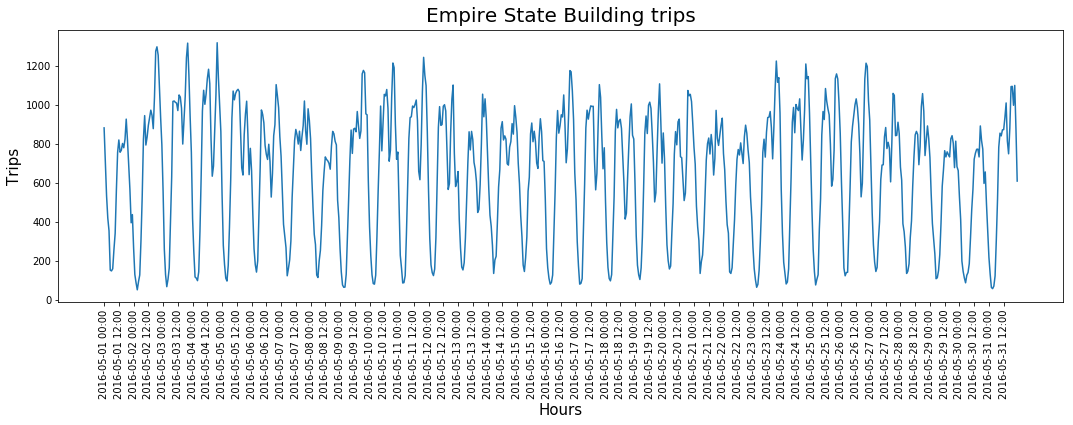

In [13]:
longitude = -73.985428
latitude = 40.748817
row = count_data[(count_data.west <= longitude) & 
                 (count_data.east >= longitude) & 
                 (count_data.south <= latitude) & 
                 (count_data.north >= latitude)]
trips = np.array(row.iloc[0, 5:])
hours = list(range(len(trips)))
labels = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M') for i in list(row.columns[5:])]
plt.figure(figsize=(18, 5))
plt.plot(hours, trips)
plt.xlabel('Hours', fontsize=15)
plt.xticks(hours[::12], labels[::12], rotation='vertical')
plt.ylabel('Trips', fontsize=15)
plt.title('Empire State Building trips', fontsize=20, y=1.01)
plt.show()


### 5. Нули 

In [14]:
data = np.array(count_data.iloc[:, 5:])
num_of_zeros = data.size - np.count_nonzero(data)
print('Всего в мае 2016 года {} пар час-ячейка. Из них {} - нулевые, т.е. {:.0f}%.'.format(data.size,
                                                                                      num_of_zeros,
                                                                                     (num_of_zeros / data.size) * 100))

Всего в мае 2016 года 1860000 пар час-ячейка. Из них 1718238 - нулевые, т.е. 92%.


### 6. Визуализация количества поездок в полдень 2016-05-01.

In [15]:
from matplotlib import patches
from matplotlib import collections

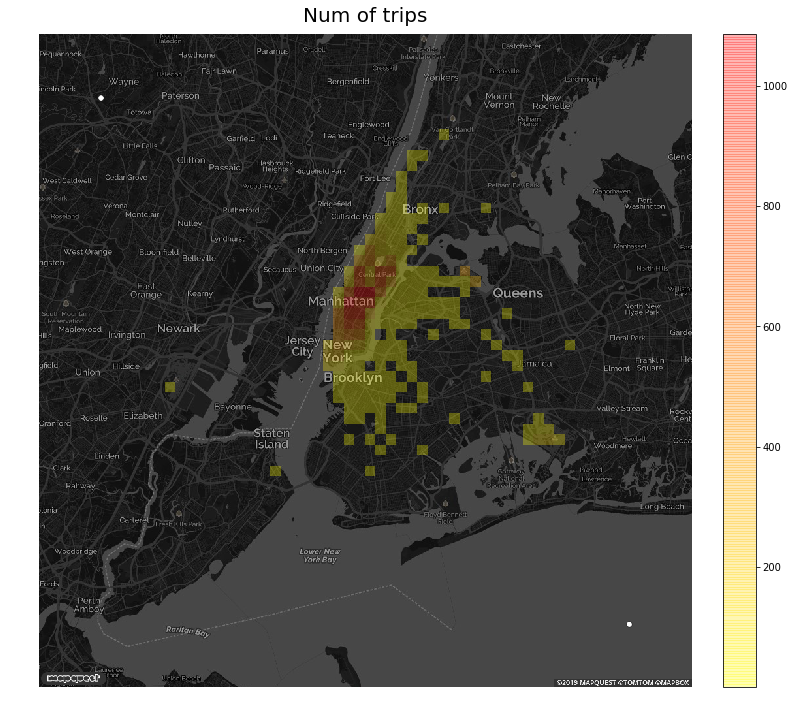

In [16]:
light = 'http://drive.google.com/uc?export=view&id=1_Ec3vB3x_QCP-vlUGQg863LI45jJeaJq'
sat = 'http://drive.google.com/uc?export=view&id=1_HfYMSevwaTart2BAgFhYhKS3KBYH-s4'
dark = 'http://drive.google.com/uc?export=view&id=135jXihmgV9GMaY7i_582Xv9dQ5_ItSDR'

hour = '2016-05-01 12:00:00'

cmap = plt.cm.autumn_r
alpha = 0.3

map_image = pltimg.imread(dark)
fig = plt.figure(figsize=(14, 12))
ax = plt.gca()
plt.imshow(map_image)

HOR_MOVE = 95 #95 #90 #100
VER_MOVE = 97 #95 #100
SCALE = 807 #813 #825 #850 #800 #900 #1000

hor_arr = np.array(regions[['west', 'east']])
min_hor = hor_arr.min()
max_hor = hor_arr.max()
hor_arr = (((hor_arr - min_hor) / (max_hor - min_hor)) * SCALE) + HOR_MOVE


ver_arr = np.array(regions[['south', 'north']])
min_ver = ver_arr.min()
max_ver = ver_arr.max()
ver_arr = (((ver_arr - min_ver) / (max_ver - min_ver)) * SCALE) + VER_MOVE

data = np.array(count_data[hour])

pts = []
colors = []
for i in range(len(hor_arr)):
    
    west = hor_arr[i][0]
    east = hor_arr[i][1]
    south = ver_arr[i][0]
    north = ver_arr[i][1]
    
    south = 1000-south
    north = 1000-north
    if data[i]:
        pts.append(patches.Rectangle([west, south], abs(west - east), north - south))
        colors.append(data[i])

collection = collections.PatchCollection(pts, cmap=cmap, alpha=alpha)
collection.set_array(np.array(colors))
cs = ax.add_collection(collection)    
plt.colorbar(cs,fraction=0.046, pad=0.04)

plt.axis('off')
plt.title('Num of trips', fontsize=20, y=1.01)
plt.show()